In [77]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [78]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [79]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [80]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [81]:
# reflect an existing database into a new model
base = automap_base()

base.prepare(engine, reflect=True)

# reflect the tables
measurement = base.classes.measurement

station = base.classes.station

C:\Users\wmk71\AppData\Local\Temp\ipykernel_10184\1738808713.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect=True)


In [82]:
# View all of the classes that automap found
for class_name in base.classes.keys():
    print(class_name)

measurement
station


In [83]:
# Save references to each table
measurement = base.classes.measurement

station = base.classes.station

In [84]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [85]:
# Find the most recent date in the data set.
most_recent = session.query(func.max(measurement.date)).scalar()

most_recent = datetime.strptime(most_recent, '%Y-%m-%d')

one_year_ago = most_recent - timedelta(days=365)

print(most_recent)

2017-08-23 00:00:00


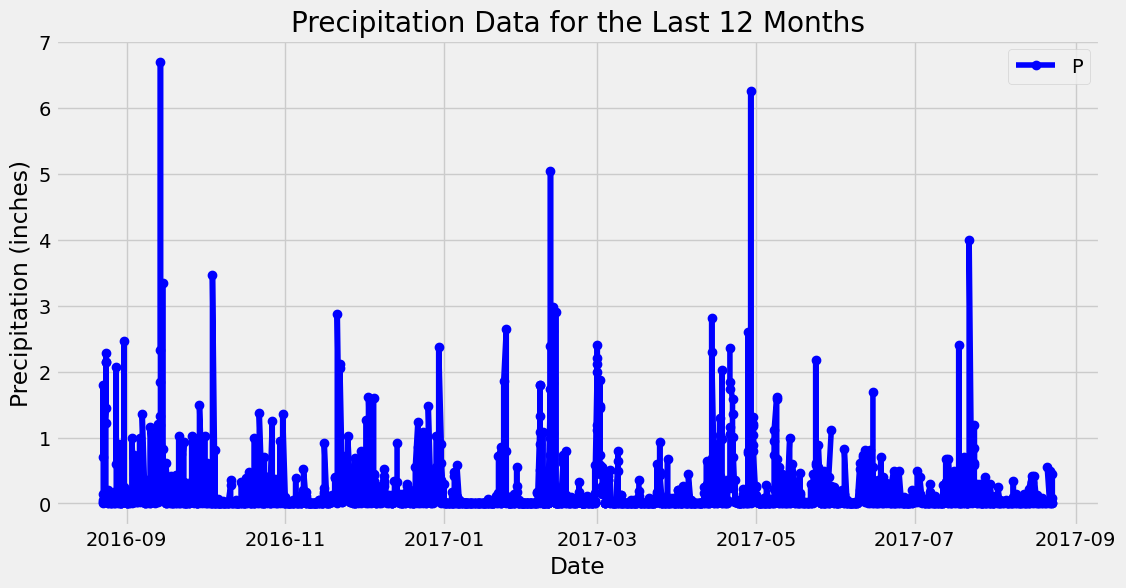

In [86]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
results = session.query(measurement.date, measurement.prcp).filter(
        measurement.date >= one_year_ago.strftime('%Y-%m-%d'),
        measurement.date <= most_recent.strftime('%Y-%m-%d')
    ).order_by(measurement.date).all() 

# Save the query results as a Pandas DataFrame. Explicitly set the column names
climate_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
climate_df['Date'] = pd.to_datetime(climate_df['Date'])
climate_df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12, 6))
plt.plot(climate_df['Date'], climate_df['Precipitation'], marker='o', linestyle='-', color='b')
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.grid(True)
plt.legend('Precipitation')
plt.show()


In [87]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = climate_df['Precipitation'].describe()
summary_stats

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [88]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()

In [89]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = (
    session.query(station.station, func.count(measurement.station).label('count'))
    .join(measurement, station.station == measurement.station)
    .group_by(station.station)  # Group by station
    .order_by(func.count(measurement.station).desc())
    .all()
)

most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [90]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = 'USC00519281'
temperature_stats = (
    session.query(
        func.min(measurement.tobs).label('min_temp'),
        func.max(measurement.tobs).label('max_temp'),
        func.avg(measurement.tobs).label('avg_temp')
    )
    .filter(measurement.station == station_id)
    .one()
)
temperature_stats

(54.0, 85.0, 71.66378066378067)

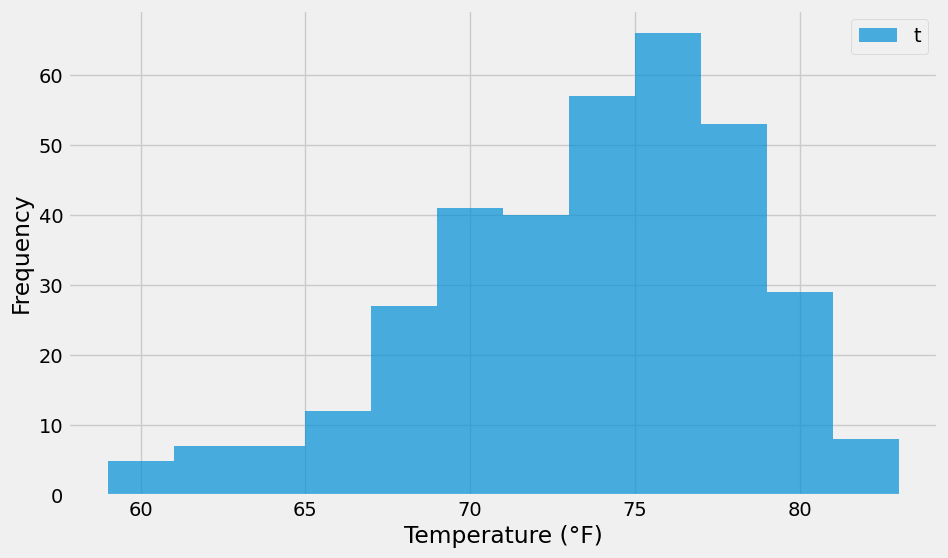

In [91]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(measurement.tobs).filter(
    measurement.station == station_id,
    measurement.date >= one_year_ago.strftime('%Y-%m-%d'),
    measurement.date <= most_recent.strftime('%Y-%m-%d')
    ).all()

temp_df = pd.DataFrame(results, columns=['Temperature'])

plt.figure(figsize=(10, 6))
plt.hist(temp_df['Temperature'], bins=12, alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend('tobs')
plt.show()


# Close Session

In [76]:
# Close Session
session.close()